# Exploratory Data Analysis (EDA) of a Pruvo dataset.
July 25 — 27th 2023
</br> Last edited: July 30th 2023
</br>by: Duarte Harris

## Introduction


## Instructions:
[recieved on July 24th 2023 14h44 by Itai Marcipar itai@pruvo.com]

Let me share with you a sample of the data we do have on our end and let me know what you think.

During the last **years** we were collecting a lot of **human decisions** regarding the **relations of 2 room types**.

In the following excel: https://docs.google.com/spreadsheets/d/1AjDaqnXrZFy3KAspjUAVo5cLt37MEVXOuBooYDM9Kr8/edit?usp=sharing

You can see the decisions made between **the original room type (Col A)** and **the proposed one (Col B)**.

**Links** = *how many times a person clicked that both rooms* in A and B are the same (if it is **higher than 6** it means someone put a *"force" match decision* – this is the **admin 1000 score** you see)

**Unlinks** = *how many times someone decided it is not a match* (different room type)

**Score** = links – unlinks + admin

I think we have **a few millions of rows** like that (of course that there are mistakes there as it was a human decision)

**Let me know what you think**…

## Initial Reflections
[first began on July 26th 2023 at around 16h15.]

It seems that in the dataset I'm about to analyze there are 2 columns (A & B), A being the original, B being the one proposed by Pruvo, then a third column called "Links" that scores how well column A & B are related by, and this is ambiguous: "how many times a person clicked that both rooms (columns) are the same", which I'm taking it to mean that several individuals, each one time, indicated that these columns (A & B) either refer in fact to the same room, or that they do not by selecting to unlink, which is represented by the next column.

Also to note that if the the number in the "Links" column is higher than 6 (was it meant "6 or higher"?), then someone "put a force match decision", being accompanied by a final column called "admin" with the value of 1_000, which I'm taking to mean that an overseer knows for a fact that these columns are the referring to the same room and is thus indicating that Col A & B as being the same room.

My first impression reading the instructions was that this would be a semi-synthetic dataset, given that there would be an overseer (or admin) that could add 1_000 points to the score straight away (potentially more if by "higher than 6" on the link column also means that he could put any value there). If this would prove to be the case, then it probably would skew the intensity of the positive scores [I assumed it was binary, i.e., 1_000 or 0 (and I wasn't far off)].

Also, "higher than 6" suggested to me that there would be 5 or 6 human deciding to link or unlink the two columns. In  which case subtracting the unlinks from the links seem to make little sense to the score ('though it didn't work quite like I was thinking, the scoring mechanism still does not seem to work). There was also no mention of a column with the name of the hotel, nor the city, which would seem crucial to identify if the room is indeed the same, or even better, a unique identifier of the hotel (of the room would be perfect but then no algorithm would be needed) regardless of being described slightly differently in different websites.

I figured that I was probably misunderstanding something about the dataset, and that it was indeed a semi-synthetic dataset that would allow for establishing a Bayes Error Rate (what to be expected from a human-level performance), which would be useful to establish an expectation of the algorithm's performance.

Curious to look at the dataset I downloaded it and got to it.

In retrospect I suspect I might made the mistake of assuming that this data, millions of rows I'd only be seeing a small sample of, was the data (partly?) used to train the algorithm that would suggest rooms to be re-booked. In the context of what we talked prior, and the description in the email, it made sense to me, but having looked at the data, either a few (a lot?) of features (columns) are absent from the dataset, or this sample is extremely skewed from the norm, or this is dataset represents something else (and I don't think being skewed would explain everything).

I lacked clarity, but having sent an email with a question without a response, I decided not to pursue the subject further and try to draw what conclusions I could from this data.

[section last edited on July 26th 2023]

## Initial Plan
The plan passed by loading the data into a DataFrame, doing a quick and simple EDA on the data to get a feel for it, see what doubts arise, and see which conclusions I could draw from it. Hopefully this will also allow me to formulate an embryo of a strategy to implement moving forward.

In [1]:
# to allow usage of pandas datastructures type annotations
from __future__ import annotations

### Libraries

In [2]:
# standard libraries
import os
import sys

# 3rd party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # vectorizers
import spacy
from tqdm.notebook import tqdm

# import language models
import en_core_web_trf

# required activations
%matplotlib inline

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # to solve the insufficient memory bug when creating NLP docs
os.environ["TOKENIZERS_PARALLELISM"] = "FALSE" # to solve the parallelism warning

sns.set(color_codes = True)

tqdm.pandas()

### Versioning

In [3]:
# Versions
print("Python:", sys.version)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("seaborn:", sns.__version__)
print("spacy:", spacy.__version__)

Python: 3.11.4 (main, Jul  5 2023, 08:41:25) [Clang 14.0.6 ]
numpy: 1.25.0
pandas: 1.5.3
seaborn: 0.12.2
spacy: 3.5.3


### Directories & Paths

In [4]:
# current dir path
PROJECT_DIR = os.path.dirname(os.getcwd())

# dataset
DATASET = "results-20230717-113545 - results-20230717-113545.csv"

## Analysis

In [5]:
# loading the ds
rooms_df = pd.read_csv(DATASET)

rooms_df

,name1,name2,type,score,admin,links,unlinks
0,twin room,"twin room, 2 twin beds",match,1963,1000,7,44
1,queen room with two queen beds,2 queen beds non-smoking,match,1004,1000,10,6
2,standard room with twin beds non refundable,twin room,match,999,1000,5,6
3,double room,room 1 double bed non smoking fullbed*,match,997,1000,5,8
4,"traditional room, 2 queen beds",queen room with two queen beds,match,995,1000,1,6
...,...,...,...,...,...,...,...
995,triple room with bathroom,quadruple room with bathroom,match,-1008,-1000,0,8
996,premier king harbor view room,the club room king city view (3 persons),match,-1023,-1000,0,23
997,premier king sky view,premier king harbor view room,match,-1023,-1000,0,23
998,premier king harbor view room,premier king sky view,match,-1023,-1000,0,23


First note that the admin can also have the value of -1_000.

If the score is equal to the links minus the unlinks, plus the admin, the first row has to be a mistake (7 - 44 + 1_000 ≠ 1963), as the score should be 963. The last row also has to be wrong, as 0 - 6 + -1_000 = -1_006, not -2_006. Will need to check for further discrepancies between these values.

Also, there are entries in "links" with less than 6 that have an "admin" value of 1_000. Does this have any particular meaning?

Also, since there are "admin" values of -1_000, does that mean that the corresponding "unlinks" should have "6 or higher"? Is it always the case?

I'll check if there are different admin values than 1_000 or - 1_000, check how many "links" are there with less than 6 with an "admin" value of 1_000, check if there are "admin" values accompanied by "unlinks" lower than 6, and load an extended head and tail of the DF until I can include at least an entry with a different admin value if there are.

In [6]:
# checking the possible admin values in the ds
rooms_df["admin"].unique()

array([ 1000,     0, -1000])

3 possible values, 1_000, -1_000 and 0.

Checking co-occurrences of "links" with less 6 and "admin" of 1_000:

In [7]:
# querying for links under 6 and admin 1_000
rooms_df.query("links < 6 & admin == 1_000")

,name1,name2,type,score,admin,links,unlinks
2,standard room with twin beds non refundable,twin room,match,999,1000,5,6
3,double room,room 1 double bed non smoking fullbed*,match,997,1000,5,8
4,"traditional room, 2 queen beds",queen room with two queen beds,match,995,1000,1,6
6,standard double or twin,double room,match,991,1000,2,11
9,grand suite,suite grand,match,957,1000,1,44


There are 5 entries with less than 6 "links" and the "admin" value of 1_000.

Checking for "admin" values of -1_000 co-occurring with "unlinks" values of less than 6:

In [8]:
# querying for unlinks under 6 and admin -1_000
rooms_df.query("unlinks < 6 & admin == -1_000")

,name1,name2,type,score,admin,links,unlinks


There are no situations where the value of "admin" is -1_000 and the value in "unlinks" is lower than 6.

I'll now proceed by extending the head and tail of the DataFrame to see if I can find some close to the top and bottom rows.

In [9]:
# checking extended head of the DF
rooms_df.head(20)

,name1,name2,type,score,admin,links,unlinks
0,twin room,"twin room, 2 twin beds",match,1963,1000,7,44
1,queen room with two queen beds,2 queen beds non-smoking,match,1004,1000,10,6
2,standard room with twin beds non refundable,twin room,match,999,1000,5,6
3,double room,room 1 double bed non smoking fullbed*,match,997,1000,5,8
4,"traditional room, 2 queen beds",queen room with two queen beds,match,995,1000,1,6
5,double room,"standard double room, 1 queen bed",match,994,1000,6,12
6,standard double or twin,double room,match,991,1000,2,11
7,twin room,"habitación, 2 camas individuales",match,981,1000,7,26
8,classic triple room,habitación triple clásica,match,968,1000,7,39
9,grand suite,suite grand,match,957,1000,1,44


In [10]:
# checking extended tail of the DF
rooms_df.tail(20)

,name1,name2,type,score,admin,links,unlinks
980,habitación doble,room,match,-47,0,35,82
981,double classic,classic,match,-48,-1000,51,99
982,double city view,double room,match,-49,0,3,52
983,twin/double room - premium,twin room,match,-49,0,0,49
984,double queen size bed,twin room,match,-54,0,0,54
985,double pool view,double room - pool view,match,-55,0,4,59
986,room - pool view,twin/double room - pool view,match,-56,0,6,62
987,habitación doble,habitación con 2 camas individuales,match,-64,0,6,70
988,double room,deluxe suite,match,-65,0,1,66
989,double room,double room king bed - de luxe,match,-91,0,0,91


Before proceding with the dimensions of the dataset, I'll first check if there are more rows where the "score" column doesn't match with the formula described in the email.

In [11]:
# checking rows where the "score" does not correspond to the formula: score = links - unlinks + admin
rooms_df.query("score != links - unlinks + admin")

,name1,name2,type,score,admin,links,unlinks
0,twin room,"twin room, 2 twin beds",match,1963,1000,7,44
981,double classic,classic,match,-48,-1000,51,99
999,standard double room - annex,twin room,match,-2006,-1000,0,6


There are 3 rows where the score does not match the formula in the email: the two previously identified and the iloc[981] that should be -1_048, and not -48.

These mistakes, if they are mistakes, must be identified and either clarified, corrected or dropped eventually (probably out of scope of this exercise).

On with the dataset dimensions and descriptive statistics.

In [12]:
# ds dimensions
ds_shape = rooms_df.shape
print(f"# Cols: {ds_shape[1]}\n# Rows: {ds_shape[0]}")

# Cols: 7
# Rows: 1000


### Dataset Descriptive Statistics

In [13]:
# checking full descriptive stats
rooms_df.describe(include= "all")

,name1,name2,type,score,admin,links,unlinks
count,1000,1000,1000,1000.000000,1000.000000,1000.000000,1000.00000
unique,667,694,2,NaN,NaN,NaN,NaN
top,double room,double room,match,NaN,NaN,NaN,NaN
freq,71,66,975,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,-4.803000,5.000000,1.265000,12.06800
std,NaN,NaN,NaN,148.822668,130.353335,5.712916,20.38045
min,NaN,NaN,NaN,-2006.000000,-1000.000000,0.000000,6.00000
25%,NaN,NaN,NaN,-10.000000,0.000000,0.000000,6.00000
50%,NaN,NaN,NaN,-7.000000,0.000000,0.000000,8.00000
75%,NaN,NaN,NaN,-6.000000,0.000000,0.000000,11.00000


A few observations that stand out:

* Having 1_000 rows, about two thirds and 70% of the "name1" and "name2" columns respectively are unique values (before cleaning the text), sugesting an extremely varied dataset when it comes to the descriptions of the rooms. Also, there seem to be no missing values in the DF;
* There are 2 unique values for the "type" column. Since I've only noted one so far ("match"), I'll check the other when looking at the value counts. I'll also look more closely at the unique values for each column later on;
* In both "name1" and "name2", "double room" is the most common description;
* A mean negative "score" is unexpected at this moment. While it could be due to errors in the scoring column before cleaning, the quantiles suggest otherwise, as it seems that the vast majority of scores and in fact negative;
* A negative minimum of -2_006 would be unexpected, where it not for having finding it earlier as a probably mistake when filling of the "score";
* The rest of the statistics suggest a highly skewed dataset. To be investigated.

In [14]:
# checking the cols data types
rooms_df.dtypes

name1      object
name2      object
type       object
score       int64
admin       int64
links       int64
unlinks     int64
dtype: object

### Data Distribution

array([[<Axes: title={'center': 'score'}>,
        <Axes: title={'center': 'admin'}>],
       [<Axes: title={'center': 'links'}>,
        <Axes: title={'center': 'unlinks'}>]], dtype=object)

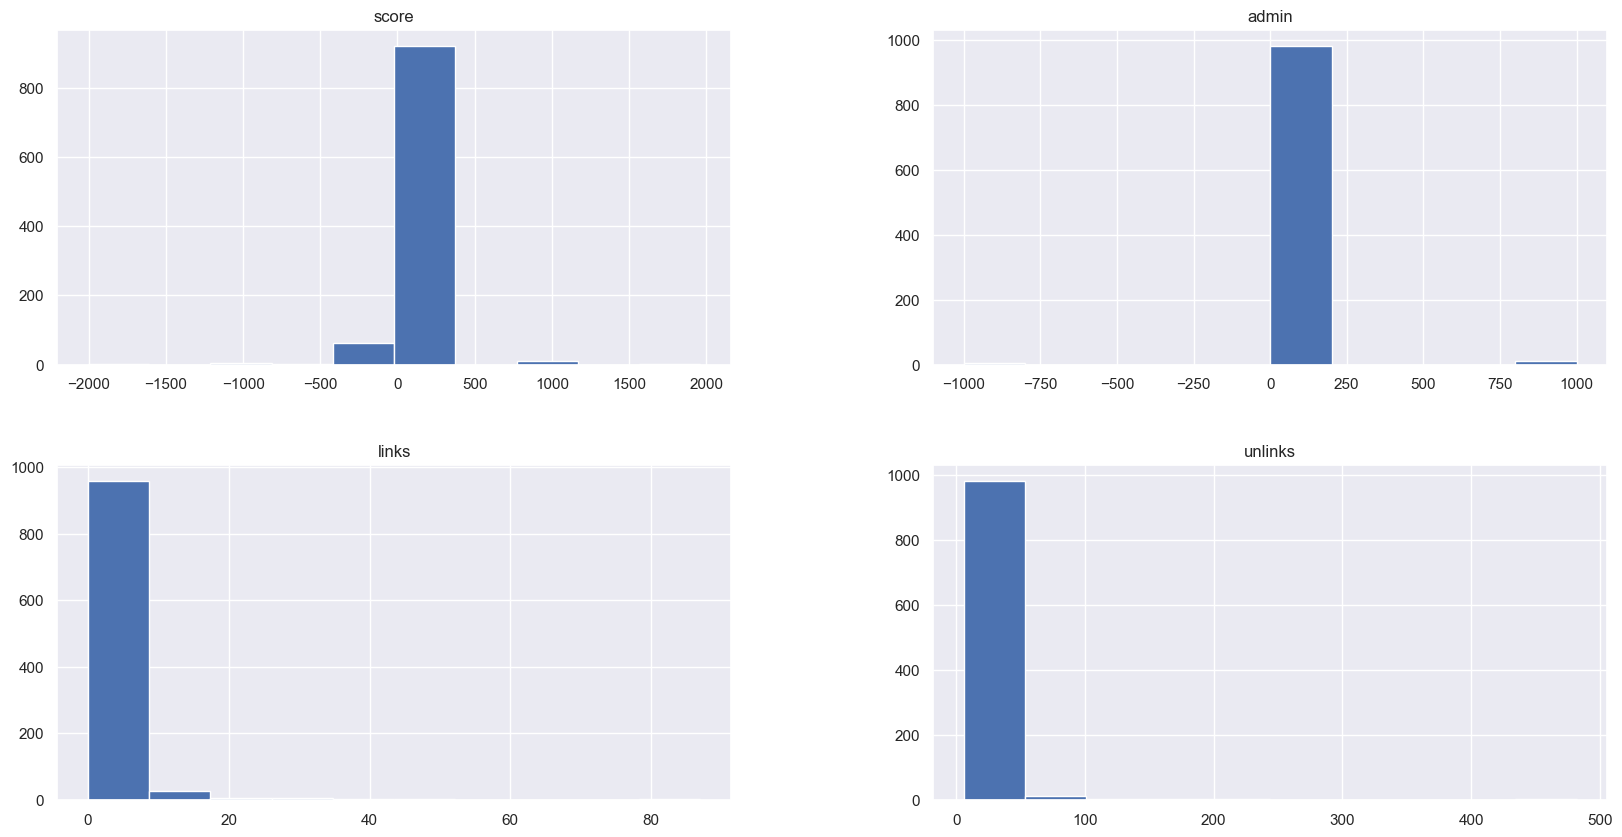

In [15]:
# plotting histograms of the variables
rooms_df.hist(figsize= (20, 10))

Looking at the histograms in slightly more detail. I'll set "score" and "admin" in 3 bins, as the 3 unique values of "admin" seem to dominate the data, then I'll leave "links" and "unlinks" free.

Text(0.5, 1.0, 'Frequency of score (in 3 bins)')

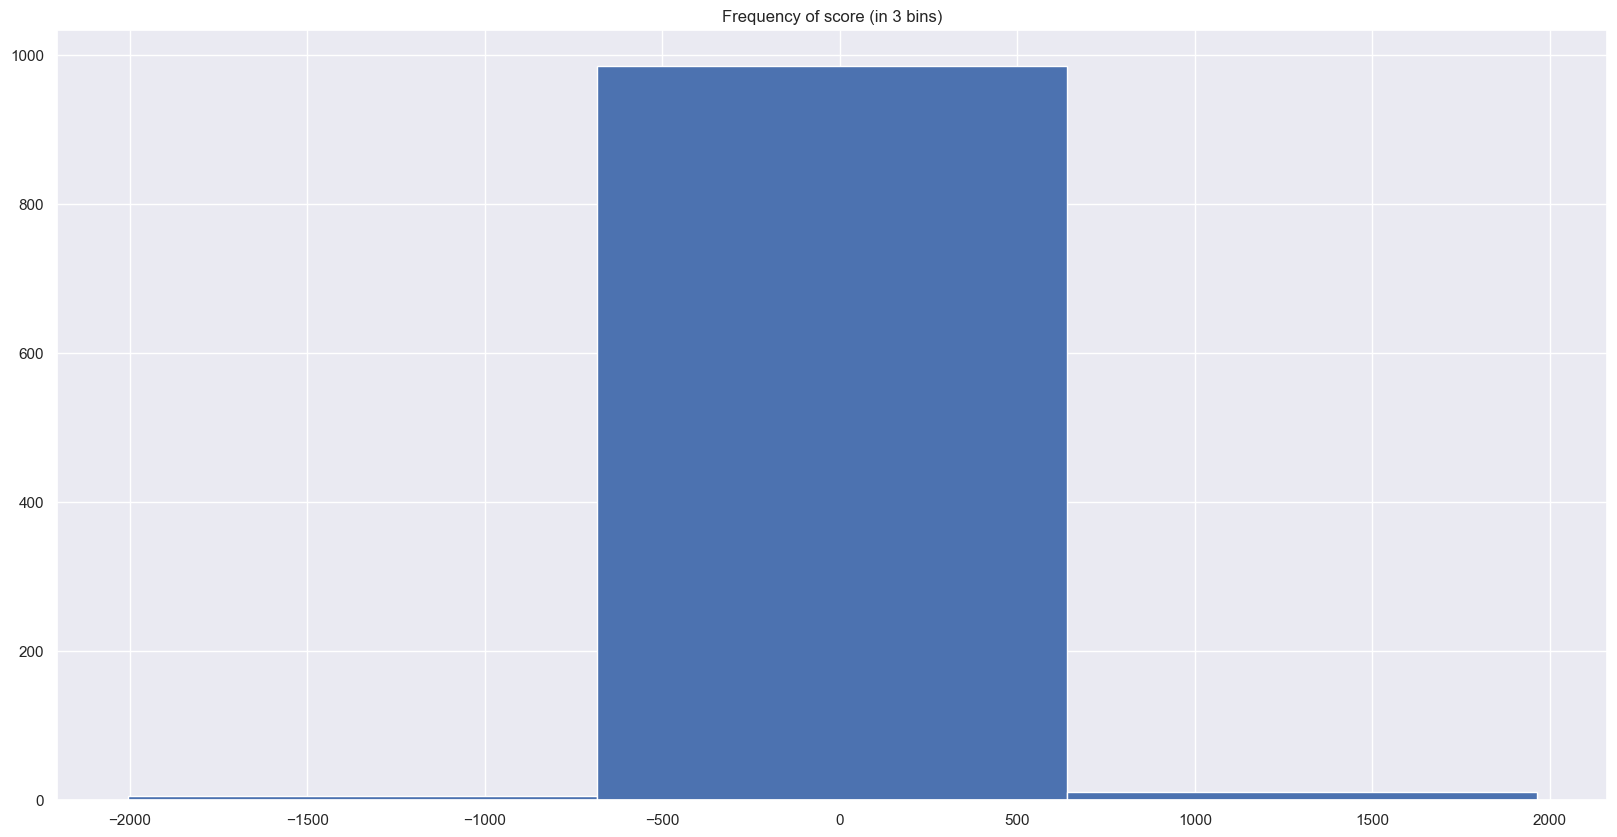

In [16]:
# plotting histograms of score
rooms_df["score"].hist(figsize= (20, 10), bins= 3)
plt.title("Frequency of score (in 3 bins)")

Text(0.5, 1.0, 'Frequency of admin (in 3 bins)')

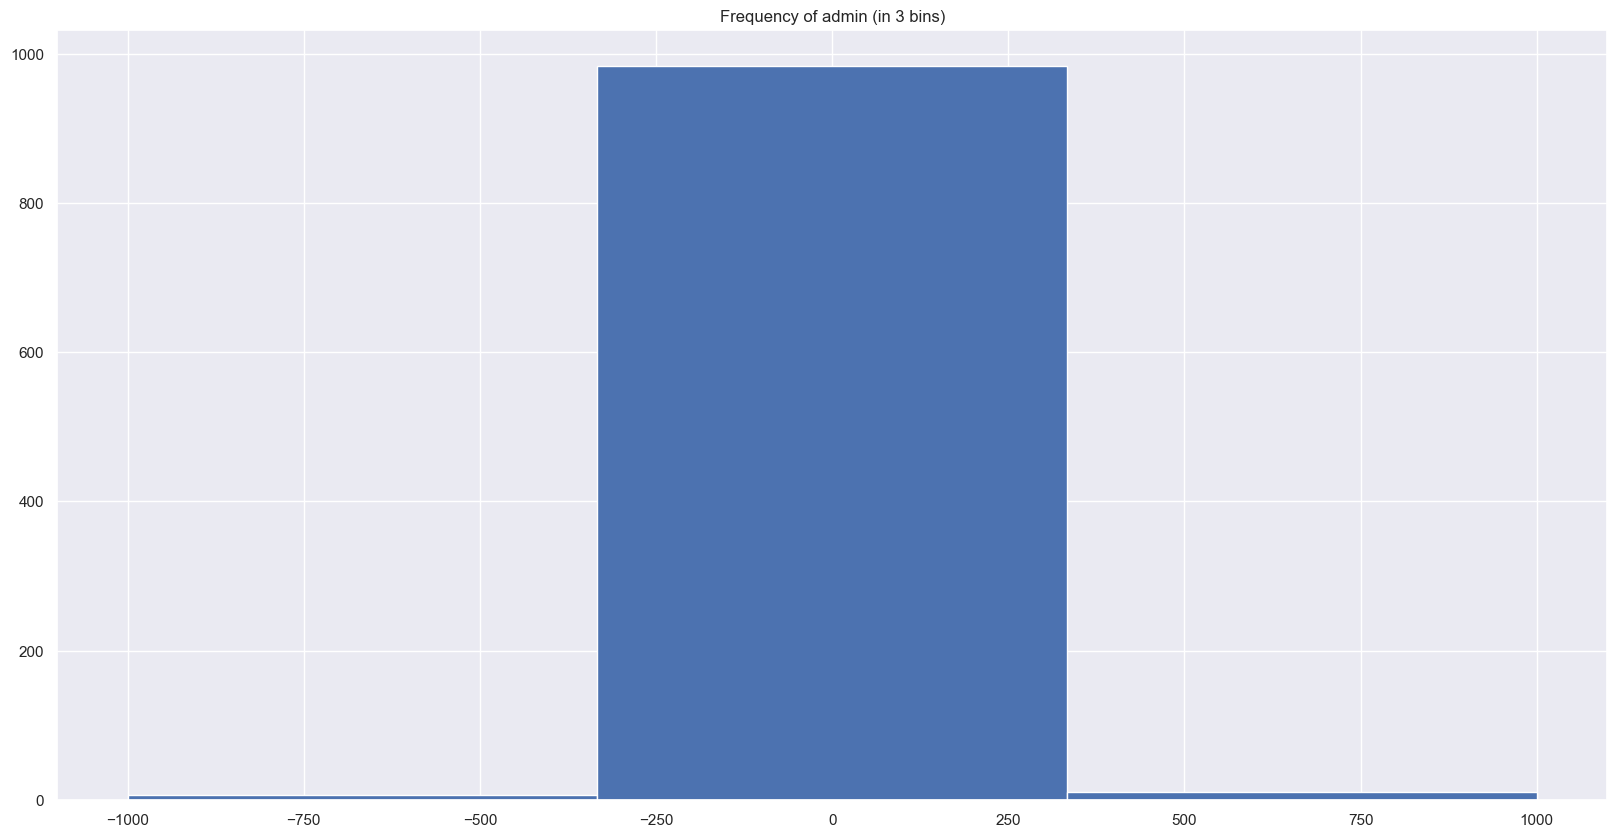

In [17]:
# plotting histograms of admin
rooms_df["admin"].hist(figsize= (20, 10), bins= 3)
plt.title("Frequency of admin (in 3 bins)")

Text(0.5, 1.0, 'Frequency of links')

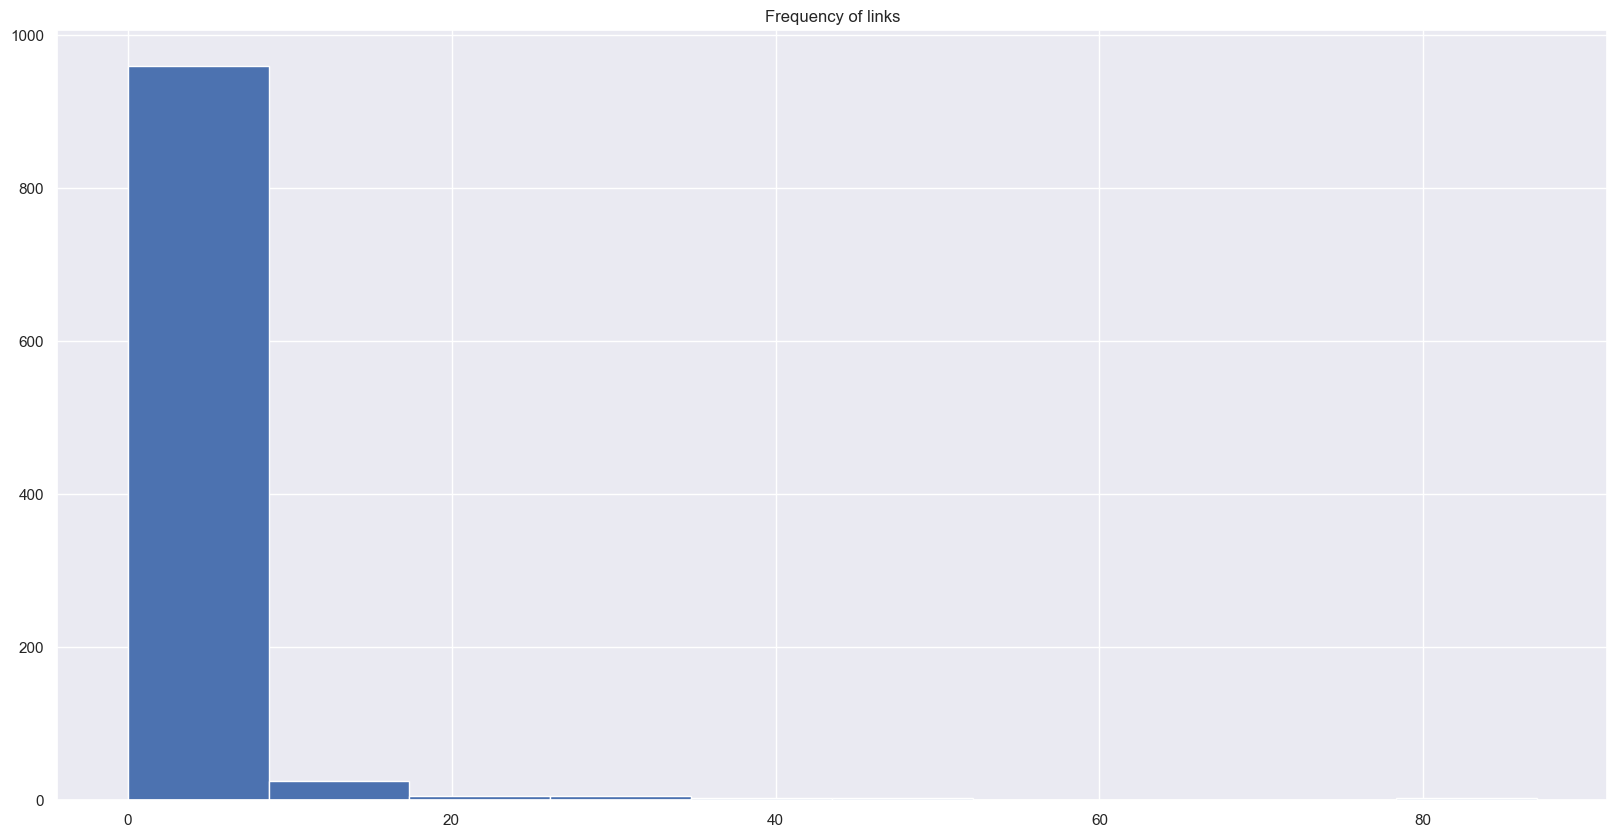

In [18]:
# plotting histograms of links
rooms_df["links"].hist(figsize= (20, 10))
plt.title("Frequency of links")

Text(0.5, 1.0, 'Frequency of unlinks')

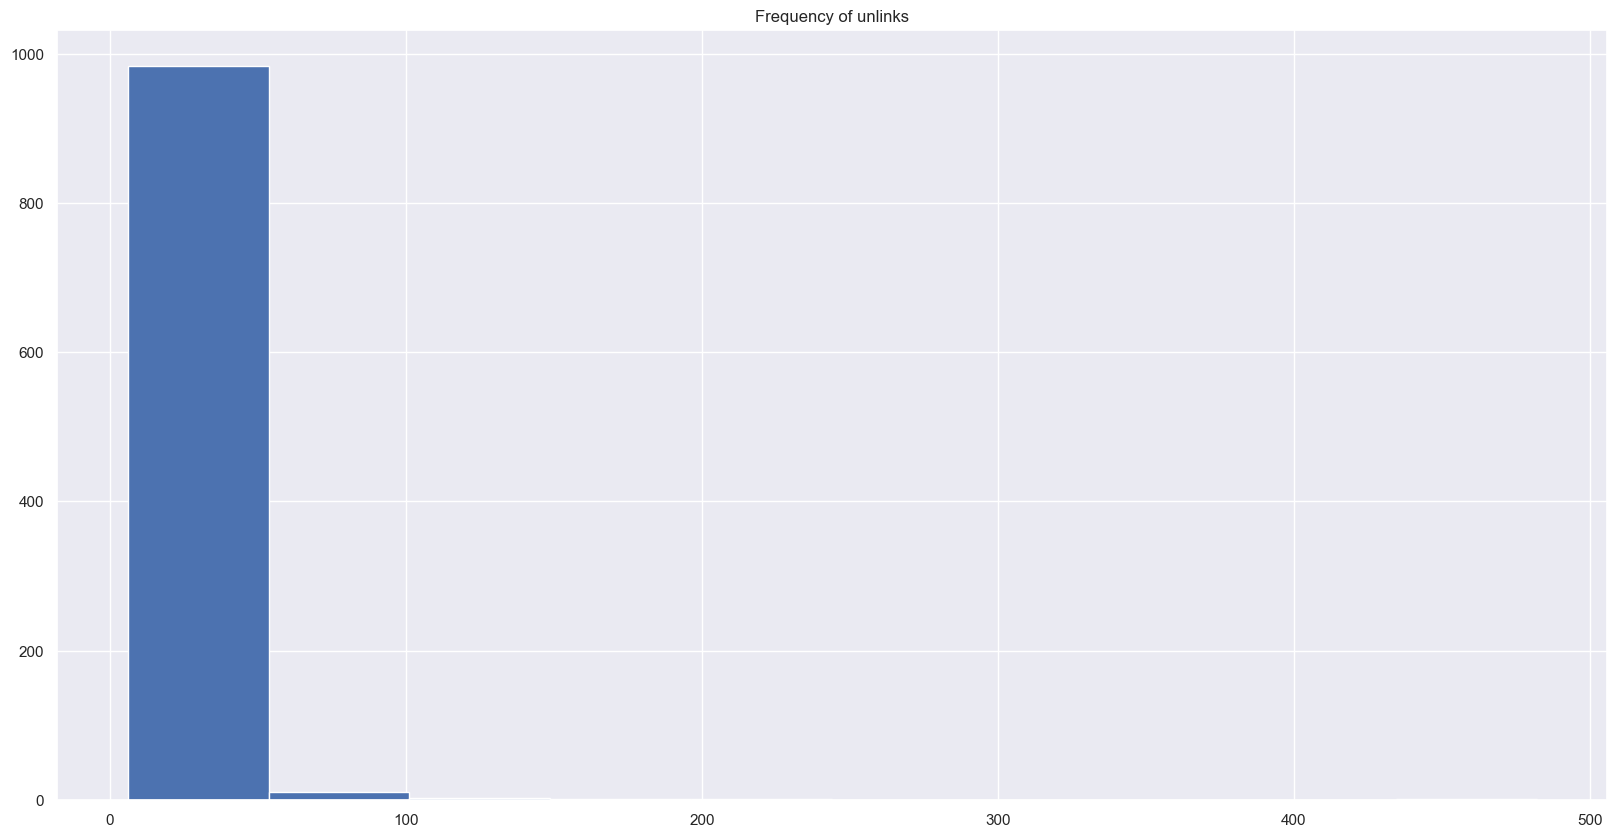

In [19]:
# plotting histograms of unlinks
rooms_df["unlinks"].hist(figsize= (20, 10))
plt.title("Frequency of unlinks")

As suspected, these visualizations indicate a highly skewed dataset (sample?).

<Axes: xlabel='admin', ylabel='score'>

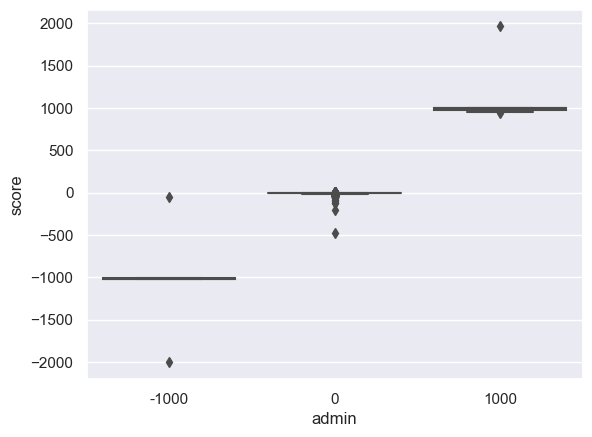

In [20]:
# plotting box plot to viz the relationship between score & admin
sns.boxplot(x= "admin", y= "score", data= rooms_df)

Also as expected, these boxplots support the idea that the main contributor to the "score" to be the "admin" values. It also finds the mistakes(?) encountered above appearing as outliers, 'though there are some that should be further investigated such as the score value of close(?) to zero with -1_000 admin value, or the outlier with a close to(?) -500 score with an admin value of 0.

Although these outliers warrant an investigation, I'll leave out of the scope of this analysis.

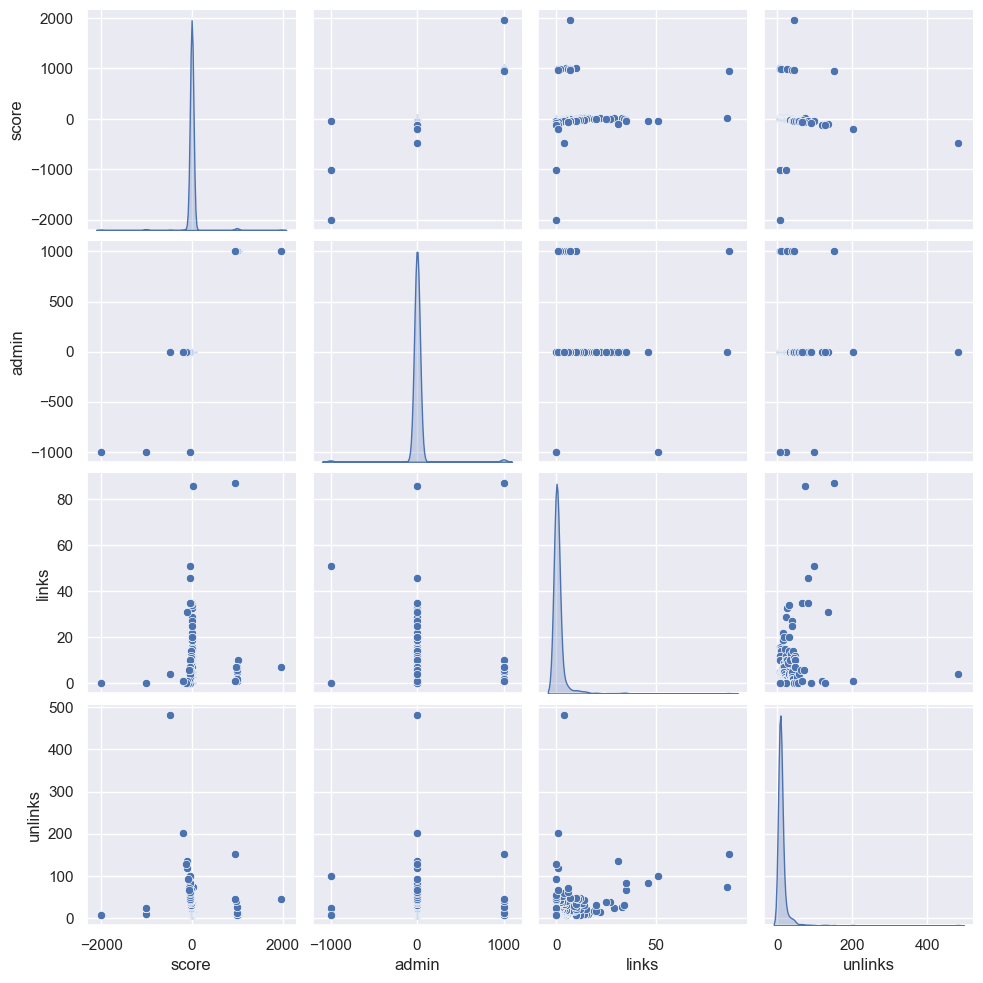

In [21]:
# building pairplot
sns.pairplot(rooms_df, diag_kind= "kde")

The pairplot suggests little to no (cor)relation between the numerical features of the dataset, except, perhaps, for the "admin" values and the "score" values (their shape resembles a sigmoidal), in particular if they're corrected (which is to be expected given the description of the formula to calculate the score).

In any case I'll draw a correlation matrix just to make sure before proceeding by checking the unique value counts and value counts for each column below.

In [22]:
# correlation matrix heatmap func
def corr_heatmap(data):
    """
    Create a correlation matrix, then show its heatmap.
    NOTE: add typehints to this function
    """
    # correlation matrix to prepare the heatmap
    corr_matrix = data.corr(numeric_only= True)

    # creating the heatmap
    # setting the style
    sns.set("notebook")

    # generating a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype= bool))

    # plotting
    fig, ax = plt.subplots(figsize = (10, 10))
    with sns.axes_style("white"):
        p2 = sns.heatmap(corr_matrix,
                         mask= mask,
                         square= True,
                         fmt= "0.2g",
                         vmin= -1,
                         vmax= 1,
                         center= 0,
                         cmap= sns.diverging_palette(20, 220, n = 200),
                         annot= True)

    return p2

<Axes: >

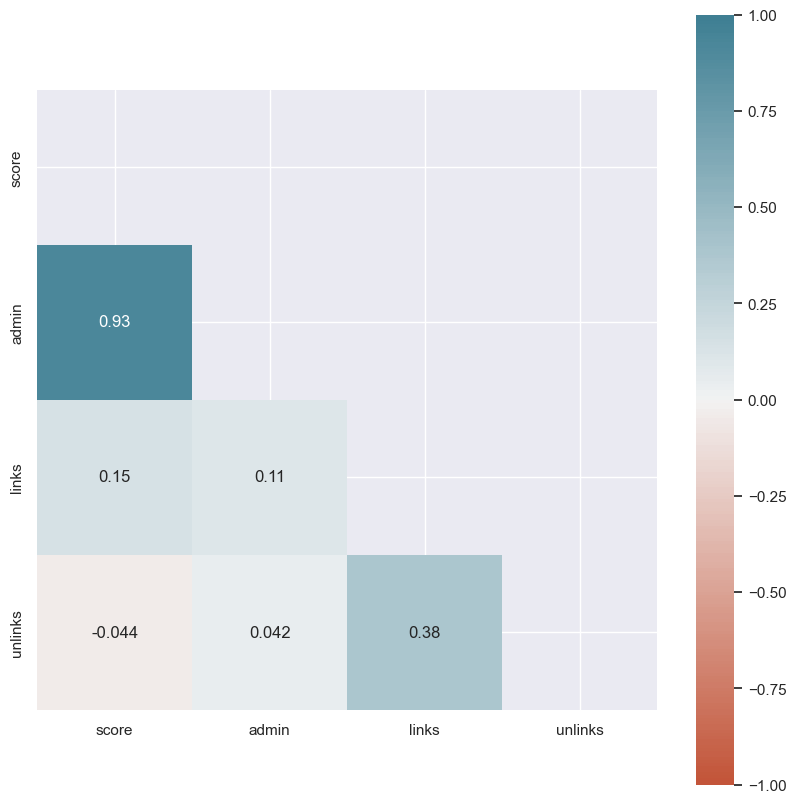

In [23]:
# checking correlations
corr_heatmap(rooms_df)

As expected, besides "score" with "admin", there's no significant correlation between the remaining cols.

Let's see if this remains if we remove "admin" from the correlation analysis:

<Axes: >

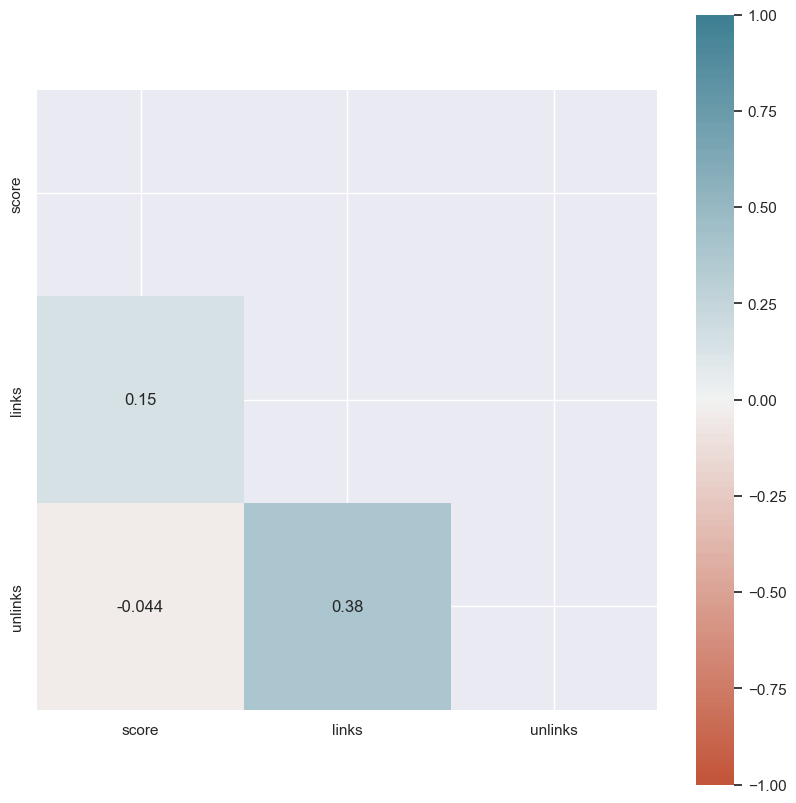

In [24]:
# checking correlations w/out the admin col
corr_heatmap(rooms_df.drop(columns= ["admin"]))

As we can see there's no significant relation between the score and the remaining columns if we maintain scores affected by the "admin" value, so let's remove those as well and check again:

<Axes: >

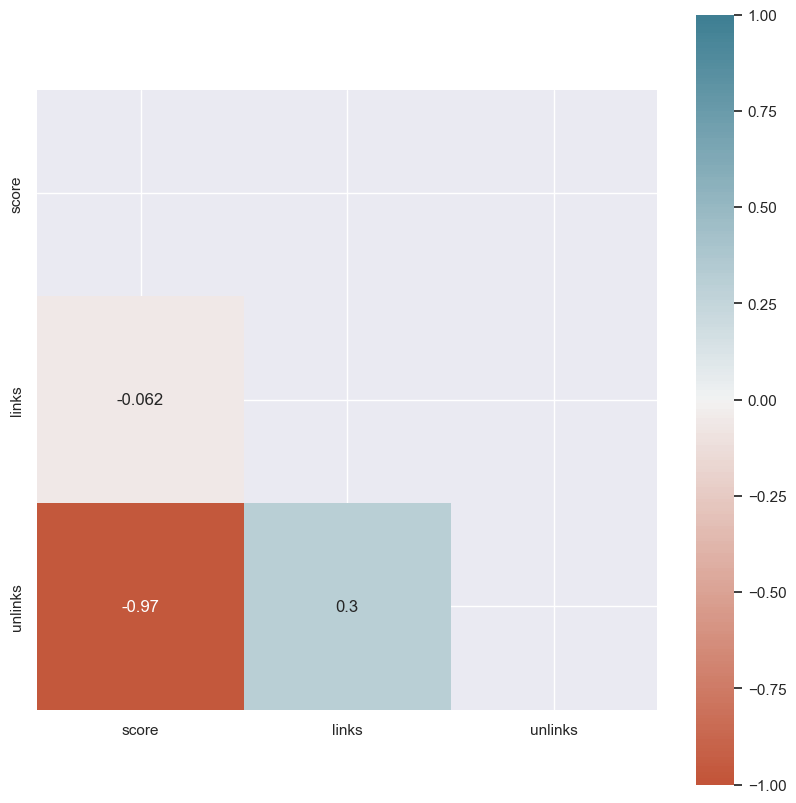

In [25]:
# checking correlations with only admin scores at 0
corr_heatmap(rooms_df.query("admin == 0").drop(columns= ["admin"]))

As we can see, if we disregard "admin" and it's values, "unlinks" shows itself to be an amazing predictor of a negative score (extremely high negative correlation). This might be what was mentioned in the interview as "negatively successful".

In [26]:
# checking unique value counts
rooms_df.nunique()

name1      667
name2      694
type         2
score       69
admin        3
links       30
unlinks     58
dtype: int64

At this point I expected more variability in the "unlinks" and in particular in the "links" column, but this feeds into the skewness of the dataset and the unreasonable weight of the "admin" values for the score.

In [27]:
# checking value counts of type
rooms_df["type"].value_counts()

match      975
upgrade     25
Name: type, dtype: int64

Here is the second unique value for the "type" column: "upgrade". Does "upgrade" mean that the room that was (perhaps) suggested in "name2" is suggested as an upgrade? If so how is this dealt with in terms of a business and algorithmic perspectives?

In [93]:
# checking value counts of score
# needed to iterate over them to print more in the output so as to share a better perspective
list(iter(rooms_df["score"].value_counts().items()))

[(-6, 355),
 (-7, 157),
 (-8, 113),
 (-9, 75),
 (-10, 50),
 (-11, 36),
 (-12, 26),
 (-13, 18),
 (-16, 16),
 (-14, 16),
 (-15, 12),
 (-17, 9),
 (-18, 8),
 (-20, 6),
 (-21, 6),
 (-35, 5),
 (-24, 4),
 (-30, 4),
 (-36, 4),
 (-23, 4),
 (5, 4),
 (4, 4),
 (-34, 3),
 (6, 3),
 (8, 3),
 (-39, 3),
 (-1023, 3),
 (-28, 3),
 (-19, 3),
 (-31, 2),
 (-29, 2),
 (-49, 2),
 (-43, 2),
 (-33, 2),
 (-40, 2),
 (-27, 2),
 (-47, 1),
 (-478, 1),
 (-1008, 1),
 (-56, 1),
 (-48, 1),
 (-54, 1),
 (-55, 1),
 (-127, 1),
 (-118, 1),
 (-103, 1),
 (-91, 1),
 (-65, 1),
 (-64, 1),
 (-44, 1),
 (-200, 1),
 (1963, 1),
 (-32, 1),
 (968, 1),
 (999, 1),
 (997, 1),
 (995, 1),
 (994, 1),
 (991, 1),
 (981, 1),
 (957, 1),
 (-26, 1),
 (936, 1),
 (13, 1),
 (3, 1),
 (-22, 1),
 (1004, 1),
 (-25, 1),
 (-2006, 1)]

No surprises here after the analysis done so far, as it is in line with the skewness, the average negative values, etc. Makes me wonder a little bit if in the same way that "higher than 6" supposedly having a particular meaning in the "links" column, the negative value counts of the values between -6 and -9 here hold a particular meaning as well.

In [29]:
# checking value counts of admin
rooms_df["admin"].value_counts()

 0       983
 1000     11
-1000      6
Name: admin, dtype: int64

There aren't many "admin" entries with 1_000, and even less (almost half) with -1_000. This might be interesting given than there seem to be so many negative scores.

In fact *this might be the most obvious conclusion of this analysis*: **There haven't been many times where the room descriptions present in "name1" and "name2" have been considered to coincide (linked)** in this sample.

With this in mind, lets see how many entries have a positive score:

In [30]:
# checking how many entries have positive scores
print(f"# of entries with positive scores: {rooms_df.query('score > 0').shape[0]}")

rooms_df.query("score > 0")

# of entries with positive scores: 27


,name1,name2,type,score,admin,links,unlinks
0,twin room,"twin room, 2 twin beds",match,1963,1000,7,44
1,queen room with two queen beds,2 queen beds non-smoking,match,1004,1000,10,6
2,standard room with twin beds non refundable,twin room,match,999,1000,5,6
3,double room,room 1 double bed non smoking fullbed*,match,997,1000,5,8
4,"traditional room, 2 queen beds",queen room with two queen beds,match,995,1000,1,6
5,double room,"standard double room, 1 queen bed",match,994,1000,6,12
6,standard double or twin,double room,match,991,1000,2,11
7,twin room,"habitación, 2 camas individuales",match,981,1000,7,26
8,classic triple room,habitación triple clásica,match,968,1000,7,39
9,grand suite,suite grand,match,957,1000,1,44


Since **there are only 27 entries with a positive score** out of a thousand entries (**less than 3%**), and seeing that 11 of those are with "admin" values of 1_000, and of those only one has a positive relation between the links and unlinks, **this would suggest that only 17 (or 1.7%) of the total entries in this dataset have an organic positive score**, which **organic or not, does not seem viable to create an algorithm to match "name1" and "name2" based on this "score"**; at least given this sample.

Also, of these none have and "admin" value of -1_000, making me wonder why is this value present in this dataset, what is it's meaning? Could it be to indicate when the description in "name1" and "name2" coincide but it does not in fact refer to the same room?

Let's see how many entries there are with a negative "score" and an "admin" value that's not -1_000 before continuing with the analysis.

In [31]:
# checking how many entries have negative scores & admin values different than -1_000
print(f"# of entries with positive scores: {rooms_df.query('score < 0 & admin != -1_000').shape[0]}")

rooms_df.query('score < 0 & admin != -1_000')

# of entries with positive scores: 967


,name1,name2,type,score,admin,links,unlinks
27,double or twin sea view,sea view room,match,-6,0,15,21
28,standard room pool view,double pool view,match,-6,0,6,12
29,twin room,standard room.,match,-6,0,5,11
30,habitacion doble (2 camas) - classic,habitacion doble (cama doble) - classic,match,-6,0,4,10
31,twin room,standard room ( no breakfast ),match,-6,0,4,10
...,...,...,...,...,...,...,...
990,double or twin sea view,room - sea view,match,-103,0,31,134
991,deluxe room,twin room,match,-118,0,1,119
992,double room,double room sea view,match,-127,0,0,127
993,run of the house,double room,match,-200,0,1,201


There are 967 entries with a negative "score" and an "admin" value that's not -1_000, or 96.7% of the dataset/sample. It's almost all of them. This could suggest Rare Events Detection or Anomaly Detection has an approach to identify when a room should be suggested, as it's used when we have an imbalanced dataset (as we see here) and we attempt to identify (detect) events with high impact but low probability of occurring, which seems to be the case. Perhaps using Autoencoders.

That said, given the structure of the dataset I'm not at this point sure it would in fact work. Further investigation is warranted.

In [32]:
# checking value counts of links
rooms_df["links"].value_counts()

0     808
1      69
2      29
4      17
3      13
5      11
10      8
7       7
6       5
12      4
14      4
9       3
15      2
16      2
35      2
20      2
27      1
25      1
11      1
46      1
51      1
13      1
34      1
19      1
29      1
22      1
33      1
86      1
87      1
31      1
Name: links, dtype: int64

Over 80% of the dataset contains 0 as the value for "links". In other words: **no link was found between "name1" and "name2" over 80% of the times** in this sample.

In [33]:
# checking value counts of unlinks
rooms_df["unlinks"].value_counts()

6      339
7      150
8      119
9       73
10      58
11      35
12      33
16      19
14      18
13      18
18      13
15      12
17      11
21      11
23       6
38       5
46       5
30       5
22       4
20       4
31       4
25       4
35       3
19       3
43       3
26       3
44       3
32       2
82       2
42       2
34       2
24       2
27       2
29       2
39       2
49       1
201      1
127      1
119      1
134      1
91       1
66       1
70       1
62       1
59       1
54       1
52       1
28       1
99       1
151      1
73       1
40       1
45       1
37       1
36       1
65       1
33       1
482      1
Name: unlinks, dtype: int64

In [94]:
# confirming there are no unlinks that are 0
print(f"There are no entries with 0 'unlinks': {rooms_df['unlinks'].value_counts().get(0) is None}")

There are no entries with 0 'unlinks': True


Nothing to add about the "unlinks" at this moment except that this means that all entries, even highly positively scored entries, have unlinks, while there are entries with no links.

Going to look at the "upgrade" entries in "type" to see what I find.

In [35]:
# checking upgrades
print("# of entires that are of type upgrade:", rooms_df.query("type == 'upgrade'").shape[0])
rooms_df.query("type == 'upgrade'")

# of entires that are of type upgrade: 25


,name1,name2,type,score,admin,links,unlinks
287,standard double room,standard single room (single bed),upgrade,-6,0,0,6
288,standard double room,"habitación doble, baño compartido",upgrade,-6,0,0,6
289,superior double room,executive double room (full double bed) (queen...,upgrade,-6,0,0,6
290,superior double room,comfort double room (2 twin beds),upgrade,-6,0,0,6
291,superior double room,room with balcony,upgrade,-6,0,0,6
292,single,double economy,upgrade,-6,0,0,6
293,twin,standard room.,upgrade,-6,0,0,6
294,standard double or twin room,standard double or twin room - single occupancy,upgrade,-6,0,0,6
295,superior room,double premium : room only,upgrade,-6,0,0,6
296,superior room,habitación premium (extralarge extrabed 2adult...,upgrade,-6,0,0,6


2.5% (or 25 entries) in this sample correspond to the "type" "upgrade".

Considering that "name2" would be the suggested upgrade, some actually seem downgrades, others the same as "name1" (and if it's the other way around the fact still remains).

That said, they all have a negative score between -6 and -9, with only one entry having a value of 1 in the "links" column (all other entries read 0).

**In any case, how should a suggestion of an upgrade be dealt with from a business and algorithmic perspective?**

Something else that stands out to me is that there are at least two different languages within both "name1" and "name2" (English and Spanish). I can test to see what languages are found within the dataset, but in any case, **what are the expectations for an algorithm do deal with multiple languages?**

In [36]:
# checking if there are null values
rooms_df.isnull().values.any()

False

It's now confirmed that there are no missing values in this dataset (unless they take the form of a specific value that has not been decleared as of this moment).

I'll now analyze the text columns.

In [37]:
# checking value counts of name1
rooms_df["name1"].value_counts()

double room                                                              71
twin room                                                                34
single room                                                              14
double classic                                                            9
room economy                                                              9
                                                                         ..
compact king room, shower only with canadian fallsview                    1
estudio, 1 cama de matrimonio grande (canadian fallsview) - semi flex     1
habitación, 2 camas de matrimonio, vistas a la ciudad - semi flex         1
habitación, 1 cama de matrimonio grande (canadian fallsview)              1
standard double room - annex                                              1
Name: name1, Length: 667, dtype: int64

At least two questions come into mind from this (I'll make more notes on this after I clean the text a little):

1) How are "double room", "twin room" and "double classic" (for example) different?
2) Let's say I have two descriptions, one "double room", another "double room with a view"; are they different or the same? Can in some cases they be the same and in others different?

If I'm understanding correctly we're trying to find the exact same room, in the same hotel, and therefore we need unique identifiers for each hotel in the world (since we don't have them for the exact same room in the exact same hotel), but if the same room can be described differently in different platforms, what would constitute a match?

More than anything else, **the Data Science Problem we're looking to answer with this dataset seems ill defined to me** at this moment.

In [38]:
# checking value counts of name1 with more than one occurrence
rooms_df["name1"].value_counts().reset_index(name= "count").query("count > 1")

,index,count
0,double room,71
1,twin room,34
2,single room,14
3,double classic,9
4,room economy,9
...,...,...
117,room 2 double beds ocean view 2 fullbed non...,2
118,superior new style - special deal package - ro...,2
119,orchid suite city view (3 persons),2
120,single superior : breakfast includedcontinenta...,2


Nothing really to add from the above analysis. Just wondering: **how has this data been collected?**

In [39]:
# checking value counts of name1 with five or more occurrences
print("# of identical descriptions with more than 5 occurrences:", rooms_df["name1"].value_counts().reset_index(name= "count").query("count >= 5").shape[0])
rooms_df["name1"].value_counts().reset_index(name= "count").query("count >= 5")

# of identical descriptions with more than 5 occurrences: 14


,index,count
0,double room,71
1,twin room,34
2,single room,14
3,double classic,9
4,room economy,9
5,standard double room,8
6,standard room non-refundable,8
7,double or twin sea view,7
8,rnbw oceanfront 2 dbl beds,7
9,queen room with two queen beds,7


Only 14 "name1" identical descriptions with 5 or more occurrences. (At least before cleaning the text data).

Note also that at least 8 times in "name1" is says that it's non-refundable. I read in the Pruvo website that the booking had to be refundable. Maybe this is different for PruvoAI, as it is B2B, not B2C, but **I'll need to clarify what's intended with this dataset**. In any case I'll check below if there are any "non refundable" or "non-refundable" entries in "name1" with an "admin" value of 1_000.

On a different subject: "dbl" seems to be an acronym — an abbreviation — of "double", making me suspect that they should be made the same in the cleaning phase (which I'm considering out of scope at the moment). But what does "rnbw" mean? And is, in any case, the idea that acronyms should be made the same as what they're abbreviating? What other acronyms are there?

In [40]:
# checking if there are entries that contain "non refundable" (or "non-refundable") and an admin value of 1_000
rooms_df.query("((name1.str.contains('non refundable')) or (name1.str.contains('non-refundable'))) & (admin == 1_000)")

,name1,name2,type,score,admin,links,unlinks
2,standard room with twin beds non refundable,twin room,match,999,1000,5,6


It's only one, but there is an entry with non refundable option in "name1" and with an admin value of 1_000. If this is merely intended to identify if it's the same room, that's ok, but if the idea is to train an algorithm to then suggest a room, it might be a problem. **Needs clarification**.

Proceeding with the value counts of "name2"

In [41]:
# checking value counts of name2
rooms_df["name2"].value_counts()

double room                                                             66
twin room                                                               44
single room                                                             13
presidential suite                                                      10
twin classic                                                             6
                                                                        ..
king room, jetted tub with premium canadian/us fallsview - semi flex     1
double (twin/double) superior                                            1
classic single                                                           1
junior suite, 1 queen bed                                                1
the club room king city view (3 persons)                                 1
Name: name2, Length: 694, dtype: int64

In [42]:
# checking value counts of name2 with five or more occurrences
print("Value counts in name2 with 5 or more occurrences:", rooms_df["name2"].value_counts().reset_index(name= "count").query("count >= 5").shape[0])
rooms_df["name2"].value_counts().reset_index(name= "count").query("count >= 5")

Value counts in name2 with 5 or more occurrences: 9


,index,count
0,double room,66
1,twin room,44
2,single room,13
3,presidential suite,10
4,twin classic,6
5,queen room with two queen beds,6
6,habitación doble,5
7,orchid suite city view,5
8,"renaissance suite, club lounge access, 1 bedro...",5


Only 9 entries with more than 5 identical occurrences for "name2". Aside from that, nothing further of note at this moment.

Text(0.5, 0, 'room description')

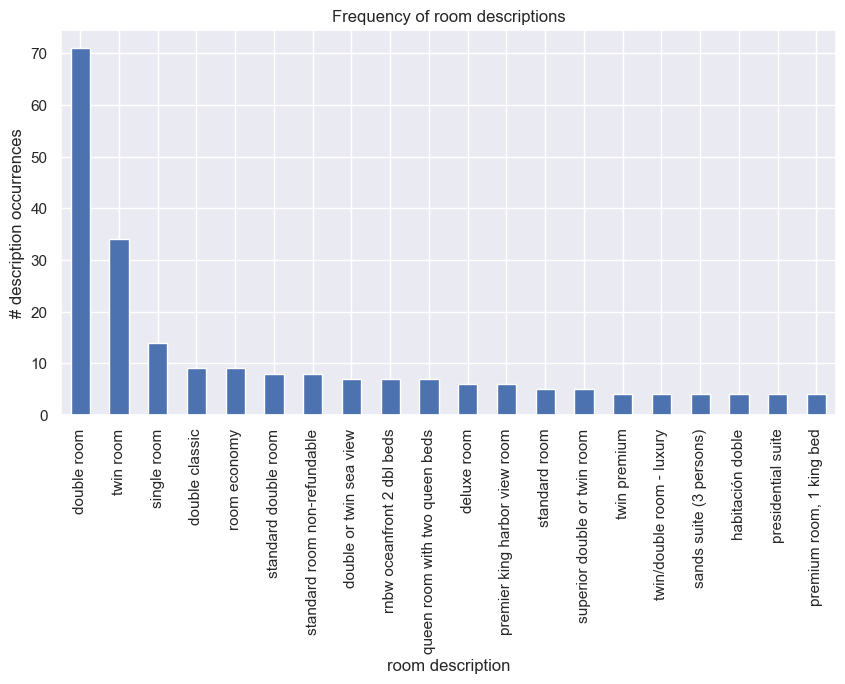

In [43]:
# plotting top name1's histogram
rooms_df["name1"].value_counts().nlargest(20).plot(kind= "bar", figsize= (10, 5))
plt.title("Frequency of room descriptions")
plt.ylabel("# description occurrences")
plt.xlabel("room description")

We can see that the data is highly unbalanced in "name1", as in the numerical columns. 

### TEXT EDA

In [44]:
# loading the language model
nlp = en_core_web_trf.load()

### Pre-Cleaning Text Analysis
Getting a sense of the frequency of the words in each of the columns.

In [45]:
# word freqs
word_freq1 = rooms_df["name1"].str.split(expand= True).stack().value_counts()
word_freq2 = rooms_df["name2"].str.split(expand= True).stack().value_counts()

# word freq of name1 col
word_freq1

room            529
double          342
-               202
twin            182
king            134
               ... 
beds...30usd      1
coffee            1
bedroom,          1
tea,express       1
double/twin-      1
Length: 536, dtype: int64

In [46]:
# showing word freq of name2 col
word_freq2

room          512
double        323
-             195
twin          180
king          133
             ... 
mob/hear        1
w/tub...30      1
usd             1
(double)        1
sole            1
Length: 568, dtype: int64

The top 5 words (or more correctly tokens, as one of them is a hyphen) in each of the columns are the same, and seem to have similar distribuitions. We can also see that some punctuation removal will be necessary.

Checking top 20 most frequent used words in "name1" followed by "name2":

In [47]:
# showing words that appear most often in name1
word_freq1[: 20]

room          529
double        342
-             202
twin          182
king          134
view          122
1             116
bed           114
2             105
standard      103
non            82
suite          79
deluxe         74
beds           68
superior       67
with           66
queen          65
single         65
room,          64
refundable     54
dtype: int64

In [48]:
# showing words that appear most often in name2
word_freq2[: 20]

room         512
double       323
-            195
twin         180
king         133
bed          131
1            127
view         116
non           98
standard      98
suite         91
2             89
deluxe        86
single        78
with          75
room,         72
queen         69
breakfast     68
superior      68
beds          65
dtype: int64

As noted above, it's clear that there are some cleaning necessary, in particular punctuation removal (it was to be expected).

"Room" is the clearly dominating word in both columns, specially considering that "room," also appears in the top 20 words in both cases more than once (if we consider "room" and "room," to be the same).

Both columns also seem to share a similar distribution.

To note that I do not identify stopwords (words that contain no semantical meaning) as easily as I would expect in the top 20. They tend to be among the most common words within a corpus, but it's not the case here (there is a case for considering "room" a stopword in this situation). Also, digits might be relevant in this case, and perhaps need to be paired with similar words, such as "1" with "single", or "2" with "double".

Note: Eventually I've came to realize that some "tradicional" stopwords (such as "side") have been removed in the cleaning process (see iloc[42] as an example) that actually can contain relevant information for this case ("ocean side view" is different from "ocean view"), so a selection of stopwords removel has to be very careful.

### Cleaning Text Data
Usually when cleaning text we follow (more or less) the steps below:

— Removing all irrelevant characters such as any non alphanumeric characters</br>
— Tokenizing the text by separating it into individual words</br>
— Removing words that are not relevant</br>
— Converting all characters to lowercase (Case Folding), in order to treat words such as “room”, “Room”, and “ROOM” the same</br>
— Considering combining misspelled or alternately spelled words to a single representation</br>
— Considering Lemmatization (reduce words such as “am”, “are”, and “is” to a common form such as “be”)</br>
— Considering removing stopwords (such as a, an, the, be) etc</br>
— Considering normalizing diacritics (such as "rosé" to "rosee")

Note: For tasks like speech recognition and information retrieval, everything is mapped to lower case. For sentiment analysis and other text classification tasks, information extraction, and machine translation, by contrast, case can be quite helpful and case folding is done or not on a case-by-case analysis (losing the difference, for example, between US the country and us the pronoun can outweigh the advantage in generality that case folding provides)

At this moment and for several reasons (including brevity) I'll do a much simplified version.

In [49]:
# creating func to clean the data
def clean_text(
    row: pd.Series[str],
    stemming: bool= False,
    casefold: bool= True,
    remove_stop: bool= True,
    remove_punct: bool= True,
) -> str:
    """
    Simple function that takes a DF row, converts it into a spacy doc for processing and depending on the
    configurations it's able to:
        * casefold it,
        * removes the punctuation,
        * removes stopwords

    Args:
        row (pd.Series[str]): pandas row containing text data.
        stemming (bool, optional): allows for stemming the words (getting them to their root). Defaults to False.
        casefold (bool, optional): wether to lowercase all words or not. Defaults to True.
        remove_stop (bool, optional): wether to remove stopwords. Defaults to True.
        remove_punct (bool, optional): wether to remove punctuation. Defaults to True.

    Returns:
        str: tokenized and clean version of the row of text data.
    """
    if casefold == True:
        # case folding the text
        text = row.lower()
    else:
        text = row

    # in order to save time I'll forcibly remove pipes (vertical bars or "|") and hifens ("-") that remained
    # attached to words using thie remaining of this function instead of trying to understand why and
    # correct that. Due to this and for future implementation if needed I'll allow a mutation for now.
    text = text.replace("|", " ")
    text = text.replace("-", " ")
    text = text.replace("(", "")
    text = text.replace("/", "")

    # generating a doc from text
    doc = nlp(text)

    # lowercase tokenizing the doc, removing stopwords & punctuation
    tokens = [
        token.lower_
        for token
        in doc
        if (token.is_stop != remove_stop)
        and (token.is_punct != remove_punct)
    ]

    return " ".join(tokens)

Runing some tests with the cleaning function. I'm using cells I've identified has being quite rich in peculiarities in the cleaning, so as to make sure everything is working as expected.

In [50]:
# testing cleaning func
example_text = rooms_df["name1"].iloc[214] # 2, 4, 10, 11, 12, 20, 22, 24, 30, 32, 33, 34, 35, 41, 51, 52, 60...
cleaned_txt = clean_text(example_text)

print(example_text)
print(cleaned_txt)

ocean view 2 double beds...50usd rsrt chg - lanai-refrigerator...access to 4 pools- mp3 clock-lux linens (corporate|odcc25)
ocean view 2 double beds 50usd rsrt chg    lanai refrigerator access 4 pools   mp3 clock lux linens corporate odcc25


In [51]:
# testing cleaning func
example_text = rooms_df["name1"].iloc[738]
cleaned_txt = clean_text(example_text)

print(example_text)
print(cleaned_txt)

\u05d1\u05e7\u05ea\u05d4 \u05d3\u05dc\u05e7\u05e1 \u05de\u05e9\u05e4\u05d7\u05ea\u05d9\u05ea \u05e2\u05dd \u05de\u05e8\u05e4\u05e1\u05ea
\u05d1\u05e7\u05ea\u05d4 \u05d3\u05dc\u05e7\u05e1 \u05de\u05e9\u05e4\u05d7\u05ea\u05d9\u05ea \u05e2\u05dd \u05de\u05e8\u05e4\u05e1\u05ea


Looking for good cells to test the cleaning function on I came across the above cell. I believe the code above might be room description in Hebrew incorrectly encoded (I find the encodings above in webpages encoded in Hebrew when I do a google search for them). When cleaning the dataset this could be tested and tried to encode correctly (Hebrew uses ISO 8859-8 for example), or simply removed.

Below is the whole row to see (before continuing with the tests):

In [52]:
# printing DF row iloc[738]
rooms_df.iloc[738:739]

,name1,name2,type,score,admin,links,unlinks
738,\u05d1\u05e7\u05ea\u05d4 \u05d3\u05dc\u05e7\u0...,\u05d1\u05e7\u05ea\u05d4 \u05d3\u05dc\u05e7\u0...,match,-10,0,0,10


In [53]:
# testing cleaning func
example_text = rooms_df["name1"].iloc[51]
cleaned_txt = clean_text(example_text)

print(example_text)
print(cleaned_txt)

habitación twin superior (2 individual(es) y 1 bebé(s) en camas existentes)
habitación twin superior 2 individuales y 1 bebés en camas existentes


In [54]:
# testing cleaning func
example_text = rooms_df["name1"].iloc[926]
cleaned_txt = clean_text(example_text)

print(example_text)
print(cleaned_txt)

connecting/ 4 persons,non-smoking (west wing)
connecting 4 persons non smoking west wing


Satisfied with the above results, I'll now apply the cleaning function to the whole dataset, creating 2 new columns with the cleaned text, "reserved" (the cleaned text of "name1") and "suggested" (the cleaned text of "name2").

In [55]:
# applying cleaning func to "name1" and "name2" cols and insert them into the DF
rooms_df["reserved"] = rooms_df["name1"].progress_apply(clean_text)
rooms_df["suggested"] = rooms_df["name2"].progress_apply(clean_text)

rooms_df

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,name1,name2,type,score,admin,links,unlinks,reserved,suggested
0,twin room,"twin room, 2 twin beds",match,1963,1000,7,44,twin room,twin room 2 twin beds
1,queen room with two queen beds,2 queen beds non-smoking,match,1004,1000,10,6,queen room queen beds,2 queen beds non smoking
2,standard room with twin beds non refundable,twin room,match,999,1000,5,6,standard room twin beds non refundable,twin room
3,double room,room 1 double bed non smoking fullbed*,match,997,1000,5,8,double room,room 1 double bed non smoking fullbed
4,"traditional room, 2 queen beds",queen room with two queen beds,match,995,1000,1,6,traditional room 2 queen beds,queen room queen beds
...,...,...,...,...,...,...,...,...,...
995,triple room with bathroom,quadruple room with bathroom,match,-1008,-1000,0,8,triple room bathroom,quadruple room bathroom
996,premier king harbor view room,the club room king city view (3 persons),match,-1023,-1000,0,23,premier king harbor view room,club room king city view 3 persons
997,premier king sky view,premier king harbor view room,match,-1023,-1000,0,23,premier king sky view,premier king harbor view room
998,premier king harbor view room,premier king sky view,match,-1023,-1000,0,23,premier king harbor view room,premier king sky view


With this done, we can now do a slightly more profound analysis.

### Post-Cleaning Text Analysis

Checking if cleaning the dataset significantly reduced the number of unique descriptions by comparison:

In [56]:
# checking how many unique values after cleaning
rooms_df[["name1", "name2", "reserved", "suggested"]].nunique()

name1        667
name2        694
reserved     654
suggested    678
dtype: int64

As we can see, it hasn't changed significantly.

Checking the word frequency with the cleaned dataset:

In [57]:
# word freqs
reserved_freq = rooms_df["reserved"].str.split(expand= True).stack().value_counts()
suggested_freq = rooms_df["suggested"].str.split(expand= True).stack().value_counts()

# word freq of reserved col
reserved_freq

room          597
double        351
twin          188
bed           159
king          141
             ... 
uso             1
individual      1
roller          1
doppia          1
connecting      1
Length: 385, dtype: int64

In [58]:
# word freq of suggested col
suggested_freq

room         591
double       331
twin         183
bed          181
non          149
            ... 
marina         1
lower          1
male           1
execuplus      1
sole           1
Length: 408, dtype: int64

In [59]:
# check how many words do we have
print(f"# of distinct words in reserved: {reserved_freq.shape[0]}\n# of distinct words in suggested: {suggested_freq.shape[0]}")

# of distinct words in reserved: 385
# of distinct words in suggested: 408


In [60]:
# check which words appear more often in reserved
reserved_freq[:20]

room          597
double        351
twin          188
bed           159
king          141
view          135
non           133
2             131
1             127
standard      105
beds           95
suite          94
deluxe         90
refundable     74
superior       74
single         66
queen          66
smoking        63
habitación     52
premium        51
dtype: int64

In [61]:
# check which words appear more often in suggested
suggested_freq[:20]

room          591
double        331
twin          183
bed           181
non           149
1             142
king          140
view          130
suite         120
2             110
standard      103
deluxe         96
beds           87
single         80
refundable     79
queen          71
superior       71
breakfast      70
smoking        64
premium        48
dtype: int64

Text(0.5, 0, 'word')

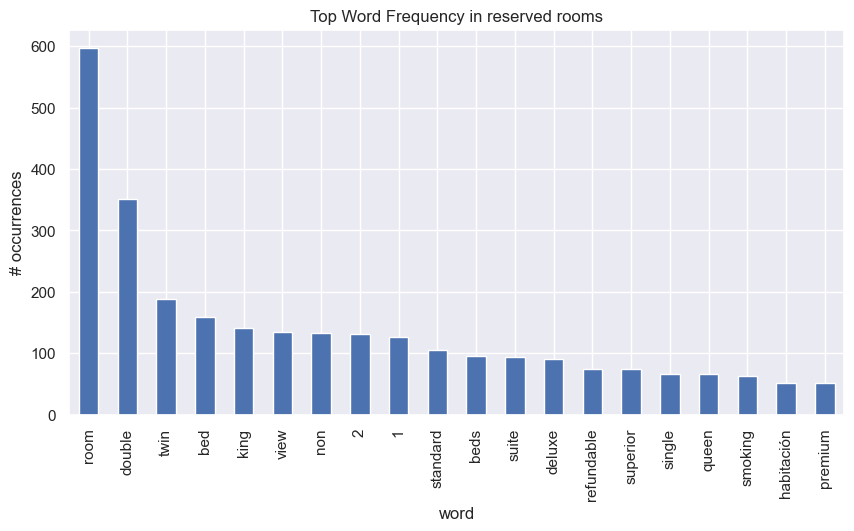

In [62]:
# plotting top reserved distribution
reserved_freq.nlargest(20).plot(kind= "bar", figsize= (10, 5))
plt.title("Top Word Frequency in reserved rooms")
plt.ylabel("# occurrences")
plt.xlabel("word")

Text(0.5, 0, 'word')

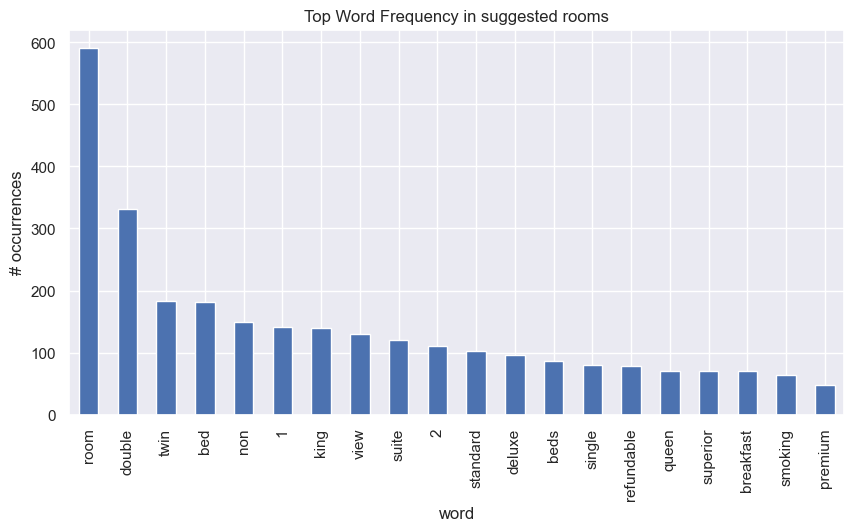

In [63]:
# plotting top suggested distribution
suggested_freq.nlargest(20).plot(kind= "bar", figsize= (10, 5))
plt.title("Top Word Frequency in suggested rooms")
plt.ylabel("# occurrences")
plt.xlabel("word")

Both show similar distribuitions. Both are similarly skewed. Might be interesting to remove the word "room" from the analysis and recheck.

### Word correlations
Checking which words/sentences co-occur more commonly for each score

In [64]:
# adding all words together for each score
reserved_score = rooms_df.groupby("score")["reserved"].apply(lambda x: " | ".join(x))
suggested_score = rooms_df.groupby("score")["suggested"].apply(lambda x: " | ".join(x))

In [65]:
# checking reserved
[
    (score, words)
    for score, words
    in zip(reserved_score.index, reserved_score)
]

[(-2006, 'standard double room    annex'),
 (-1023,
  'premier king harbor view room | premier king sky view | premier king harbor view room'),
 (-1008, 'triple room bathroom'),
 (-478, 'triple room'),
 (-200, 'run house'),
 (-127, 'double room'),
 (-118, 'deluxe room'),
 (-103, 'double twin sea view'),
 (-91, 'double room'),
 (-65, 'double room'),
 (-64, 'habitación doble'),
 (-56, 'room    pool view'),
 (-55, 'double pool view'),
 (-54, 'double queen size bed'),
 (-49, 'double city view | twindouble room    premium'),
 (-48, 'double classic'),
 (-47, 'habitación doble'),
 (-44, 'twin room'),
 (-43, 'double room | double twin sea view'),
 (-40, 'double room | superior double'),
 (-39, 'double room | premium room 1 king bed | executive suite'),
 (-36, 'standard room non refundable | premium | premium room | single room'),
 (-35,
  'double twin deluxe | double twin superior    non refunduble | double room | executive king room | single room    non smoking'),
 (-34,
  'double room | habi

In [66]:
# checking for suggested
[
    (score, words)
    for score, words
    in zip(suggested_score.index, suggested_score)
]

[(-2006, 'twin room'),
 (-1023,
  'club room king city view 3 persons | premier king harbor view room | premier king sky view'),
 (-1008, 'quadruple room bathroom'),
 (-478, 'twin room'),
 (-200, 'double room'),
 (-127, 'double room sea view'),
 (-118, 'twin room'),
 (-103, 'room    sea view'),
 (-91, 'double room king bed    de luxe'),
 (-65, 'deluxe suite'),
 (-64, 'habitación con 2 camas individuales'),
 (-56, 'twindouble room    pool view'),
 (-55, 'double room    pool view'),
 (-54, 'twin room'),
 (-49, 'double room | twin room'),
 (-48, 'classic'),
 (-47, 'room'),
 (-44, 'family room standard'),
 (-43, 'twindouble room    sea view | double twin superior sea view'),
 (-40, 'habitación estándar 2 camas individuales | twin room'),
 (-39,
  'habitación estándar con 2 camas individuales | premium room 1 king bed | presidential suite'),
 (-36, 'double room | premium room | premium | double room sole use'),
 (-35,
  'double twin deluxe    non refunduble | twindouble room    superior | h

These co-occurrences suggest that **there's little relation between reserved and suggested rooms descriptions** when looking to suggest a link between both (judging by it's score), which doesn't seem to make much sense, **as if the words and the scores are unrelated**, unless, in fact they are **because just the descriptors aren't enough** to successfully and with confidence pair two rooms, **or the score is rather meaningless**.

It has now occured to me: **are the cases of the same name1 and/or name2 being paired (linked and/or unlinked) with different name1's and/or name2's?**

Before proceeding I'll test the co-occurrence of "double room" in "reserved" and "suggested", as I believe at this moment that even with the cleaning of the dataset it's a rare occurrence (if it happens at all) with a positive score.

In [67]:
# checking co-occurrence of "double room" in both reserved and suggested cols w/a score higher than 0
rooms_df.query("reserved.str.contains('double room') & suggested.str.contains('double room') & score > 0")

,name1,name2,type,score,admin,links,unlinks,reserved,suggested
5,double room,"standard double room, 1 queen bed",match,994,1000,6,12,double room,standard double room 1 queen bed
10,standard double room (full double bed),double room,match,936,1000,87,151,standard double room double bed,double room


As suspected, it only happens twice. What if we ignore the score?

In [68]:
# checking co-occurrence of "double room" in both reserved and suggested cols
print("Co-occurrence of 'double room' in reserved and suggested:", rooms_df.query("reserved.str.contains('double room') & suggested.str.contains('double room')").shape[0])
rooms_df.query("reserved.str.contains('double room') & suggested.str.contains('double room')")

Co-occurrence of 'double room' in reserved and suggested: 54


,name1,name2,type,score,admin,links,unlinks,reserved,suggested
5,double room,"standard double room, 1 queen bed",match,994,1000,6,12,double room,standard double room 1 queen bed
10,standard double room (full double bed),double room,match,936,1000,87,151,standard double room double bed,double room
42,superior double room with sea view,superior double room with side sea view,match,-6,0,1,7,superior double room sea view,superior double room sea view
75,double room,classic double room bb,match,-6,0,0,6,double room,classic double room bb
84,double room - grand de luxe,double room,match,-6,0,0,6,double room grand de luxe,double room
89,double room,double room with domestic wings,match,-6,0,0,6,double room,double room domestic wings
90,double room,deluxe double room - non-refundable,match,-6,0,0,6,double room,deluxe double room non refundable
94,"superior double room, 1 queen bed",double room,match,-6,0,0,6,superior double room 1 queen bed,double room
97,double room - side sea view,double room,match,-6,0,0,6,double room sea view,double room
98,comfort double room - non-smoking,double room,match,-6,0,0,6,comfort double room non smoking,double room


There's a total of 54 co-occurrences of the expression "double room" in the "reserved" and "suggested" columns, 2 of which with positive scores, the other 52 with negative scores, even 'though it's the most common expression in the dataset.

Also note that the the "admin" value is 1_000 in the 2 cases where the score is positive (it would be negative otherwise), and 0 for the remaining cases.

### Word Count
We'll do something similar, but the other way around, i.e., how commonly is a reservation and/or suggestion co-occuring for each word.

In [69]:
# remove words that appear few times (this way we're removing typos and misspellings)
reserved_words = reserved_freq[reserved_freq > 40]
suggested_words = suggested_freq[suggested_freq > 40]

reserved_words

room          597
double        351
twin          188
bed           159
king          141
view          135
non           133
2             131
1             127
standard      105
beds           95
suite          94
deluxe         90
refundable     74
superior       74
single         66
queen          66
smoking        63
habitación     52
premium        51
breakfast      49
3              41
dtype: int64

In [70]:
# checking suggested_words
suggested_words

room          591
double        331
twin          183
bed           181
non           149
1             142
king          140
view          130
suite         120
2             110
standard      103
deluxe         96
beds           87
single         80
refundable     79
queen          71
superior       71
breakfast      70
smoking        64
premium        48
classic        43
habitación     42
dtype: int64

In [71]:
# initializing the vectorizer
vectorizer_reserved = CountVectorizer()
vectorizer_suggested = CountVectorizer()

# fitting the vectorizer to the corpus and applying it to the ds
count_reserved = vectorizer_reserved.fit_transform(reserved_score)
count_suggested = vectorizer_suggested.fit_transform(suggested_score)

# finding words that appear more often than the given threshold
cols_reserved = list(set(vectorizer_reserved.get_feature_names_out()).intersection(reserved_words.index))
cols_suggested = list(set(vectorizer_suggested.get_feature_names_out()).intersection(suggested_words.index))

cols_reserved

['king',
 'suite',
 'superior',
 'standard',
 'refundable',
 'beds',
 'twin',
 'double',
 'non',
 'smoking',
 'premium',
 'queen',
 'breakfast',
 'view',
 'habitación',
 'bed',
 'deluxe',
 'single',
 'room']

In [72]:
# checking cols_suggested
cols_suggested

['king',
 'suite',
 'superior',
 'standard',
 'refundable',
 'beds',
 'twin',
 'double',
 'non',
 'smoking',
 'premium',
 'queen',
 'breakfast',
 'classic',
 'view',
 'habitación',
 'bed',
 'deluxe',
 'single',
 'room']

In [73]:
# converting word counts to df
reserved_df = pd.DataFrame(
    count_reserved.toarray(),
    columns= vectorizer_reserved.get_feature_names_out(),
    index= reserved_score.index
)

suggested_df = pd.DataFrame(
    count_suggested.toarray(),
    columns= vectorizer_suggested.get_feature_names_out(),
    index= suggested_score.index
)

# allowing mutation (for now) to restrict to top words
reserved_df = reserved_df[cols_reserved]
suggested_df = suggested_df[cols_suggested]

reserved_df

,king,suite,superior,standard,refundable,beds,twin,double,non,smoking,premium,queen,breakfast,view,habitación,bed,deluxe,single,room
score,,,,,,,,,,,,,,,,,,,
-2006,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
-1023,3,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,2
-1008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
-478,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
-200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
997,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
999,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1


In [74]:
# checking suggested_df
suggested_df

,king,suite,superior,standard,refundable,beds,twin,double,non,smoking,premium,queen,breakfast,classic,view,habitación,bed,deluxe,single,room
score,,,,,,,,,,,,,,,,,,,,
-2006,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
-1023,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,2
-1008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
-478,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
-200,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,1
997,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1
999,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


The above matrices are too sparse to derive any meaningful relations from this analysis. It might be better to create different classifications (such as "single room", "double room", etc, reducing the number of classes, and classify them thusly, using the algorithm confidence in the classification as the "score" of the match instead of the above calculated "score".)

Let's look more individually, starting with the word "double" in the reserved rooms (then suggested).

In [75]:
# let's see how many times the word "double" appears for each score in reserved rooms
reserved_df["double"].sort_values(ascending= False)

score
-6       114
-7        68
-8        31
-9        26
-11       15
        ... 
-29        0
-27        0
-22        0
-1023      0
 1963      0
Name: double, Length: 69, dtype: int64

In [76]:
# let's see how many times the word "double" appears for each score in suggested rooms
suggested_df["double"].sort_values(ascending= False)

score
-6       114
-7        54
-8        40
-9        27
-11       11
        ... 
-34        0
-29        0
-27        0
-26        0
 1963      0
Name: double, Length: 69, dtype: int64

### Checking for the saturation of words for each score
As the results are so dispersed, I figured it could be more interesting to filter by the saturation of words, hopefully reducing the analysis to less but higher quality relations. Let's see:

In [77]:
# creating a saturation func
def word_sat(value: int, threshold: int) -> int:
    """
    converting small numbers to 0

    Args:
        value (int): the value in the cell to be analysed.
        threshold (int): the value which below we'll convert to 0.

    Returns:
        int: either keep the existing occurring value, or converting it to 0.
    """
    if value > threshold:
        return value
    else:
        return 0


In [78]:
# applying the saturation threshold at 5 (i.e., below 5 counts the values will be converted to 0)
count_reserved_sat = reserved_df.applymap(lambda x: word_sat(x, 5))
count_suggested_sat = suggested_df.applymap(lambda x: word_sat(x, 5))

count_reserved_sat

,king,suite,superior,standard,refundable,beds,twin,double,non,smoking,premium,queen,breakfast,view,habitación,bed,deluxe,single,room
score,,,,,,,,,,,,,,,,,,,
-2006,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-1023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-1008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-478,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [79]:
# checking count_suggested_sat
count_suggested_sat

,king,suite,superior,standard,refundable,beds,twin,double,non,smoking,premium,queen,breakfast,classic,view,habitación,bed,deluxe,single,room
score,,,,,,,,,,,,,,,,,,,,
-2006,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-1023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-1008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-478,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now that we have a saturation filter we can look more closely:

In [80]:
# for each word, get how many non-zero rows exist
nonzero_reserved = count_reserved_sat.astype(bool).sum(axis= 0)
keywords_reserved = nonzero_reserved[nonzero_reserved == 1].index.tolist()

nonzero_suggested = count_suggested_sat.astype(bool).sum(axis= 0)
keywords_suggested = nonzero_suggested[nonzero_suggested == 1].index.tolist()

keywords_reserved

['breakfast']

In [81]:
# checking keywords_suggested
keywords_suggested

['premium']

In the "reserved" column:

In [82]:
# checking reserved
count_reserved_sat[count_reserved_sat["breakfast"] > 0]

,king,suite,superior,standard,refundable,beds,twin,double,non,smoking,premium,queen,breakfast,view,habitación,bed,deluxe,single,room
score,,,,,,,,,,,,,,,,,,,
-6,50,27,41,32,33,40,53,114,52,22,18,29,35,50,25,54,29,36,198


In [83]:
count_reserved_sat[count_reserved_sat["double"] > 0]

,king,suite,superior,standard,refundable,beds,twin,double,non,smoking,premium,queen,breakfast,view,habitación,bed,deluxe,single,room
score,,,,,,,,,,,,,,,,,,,
-13,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,9
-12,0,0,0,0,0,0,9,11,0,0,0,0,0,0,0,6,0,0,18
-11,0,0,0,9,0,0,8,15,9,0,0,0,0,0,0,7,0,0,23
-10,0,8,0,0,0,0,7,14,7,6,0,0,0,0,0,8,0,0,29
-9,15,9,0,9,0,6,12,26,9,7,0,0,0,14,0,8,10,0,53
-8,22,18,7,0,6,11,26,31,12,8,7,0,0,13,0,13,22,0,64
-7,26,19,11,19,11,18,27,68,17,7,9,13,0,23,6,42,13,10,90
-6,50,27,41,32,33,40,53,114,52,22,18,29,35,50,25,54,29,36,198


In the "suggested" column:

In [84]:
# checking suggested
count_suggested_sat[count_suggested_sat["premium"] > 0]

,king,suite,superior,standard,refundable,beds,twin,double,non,smoking,premium,queen,breakfast,classic,view,habitación,bed,deluxe,single,room
score,,,,,,,,,,,,,,,,,,,,
-6,58,32,33,31,55,39,37,114,78,23,24,32,47,15,47,17,79,33,51,208


In [85]:
# checking suggested
count_suggested_sat[count_suggested_sat["breakfast"] > 0]

,king,suite,superior,standard,refundable,beds,twin,double,non,smoking,premium,queen,breakfast,classic,view,habitación,bed,deluxe,single,room
score,,,,,,,,,,,,,,,,,,,,
-7,17,23,11,18,11,21,34,54,19,7,0,9,9,7,20,0,24,17,6,86
-6,58,32,33,31,55,39,37,114,78,23,24,32,47,15,47,17,79,33,51,208


In [86]:
# checking suggested
count_suggested_sat[count_suggested_sat["double"] > 0]

,king,suite,superior,standard,refundable,beds,twin,double,non,smoking,premium,queen,breakfast,classic,view,habitación,bed,deluxe,single,room
score,,,,,,,,,,,,,,,,,,,,
-16,0,0,0,0,0,0,7,7,0,0,0,0,0,0,0,0,0,0,0,11
-12,6,0,0,0,0,0,7,10,0,0,0,0,0,0,6,0,0,0,0,16
-11,6,6,0,9,0,0,8,11,0,0,0,0,0,0,0,0,7,0,0,22
-10,11,7,0,0,0,0,8,10,0,0,0,0,0,0,0,0,11,6,0,31
-9,8,8,0,12,0,6,14,27,10,9,0,7,0,0,10,0,13,7,0,48
-8,18,29,6,11,6,0,24,40,14,7,0,0,0,0,16,7,18,12,6,59
-7,17,23,11,18,11,21,34,54,19,7,0,9,9,7,20,0,24,17,6,86
-6,58,32,33,31,55,39,37,114,78,23,24,32,47,15,47,17,79,33,51,208


I'll try to filter out the rows that do not contain non-zero elements

In [87]:
# filtering out the rows that do not contain non-zero elements
count_reserved_sat.iloc[count_reserved_sat.to_numpy().nonzero()]

,room,twin,non,view,room,room,room,double,room,twin,...,smoking,premium,queen,breakfast,view,habitación,bed,deluxe,single,room
score,,,,,,,,,,,,,,,,,,,,,
-18,7,0,0,0,7,7,7,0,7,0,...,0,0,0,0,0,0,0,0,0,7
-16,12,6,6,6,12,12,12,0,12,6,...,0,0,0,0,6,0,0,0,0,12
-16,12,6,6,6,12,12,12,0,12,6,...,0,0,0,0,6,0,0,0,0,12
-16,12,6,6,6,12,12,12,0,12,6,...,0,0,0,0,6,0,0,0,0,12
-16,12,6,6,6,12,12,12,0,12,6,...,0,0,0,0,6,0,0,0,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-6,198,53,52,50,198,198,198,114,198,53,...,22,18,29,35,50,25,54,29,36,198
-6,198,53,52,50,198,198,198,114,198,53,...,22,18,29,35,50,25,54,29,36,198
-6,198,53,52,50,198,198,198,114,198,53,...,22,18,29,35,50,25,54,29,36,198


Nothing (new) stands out to me here, but the matrices above are still too sparse. To be properly analyzed I'd have to drill down word by word, which falls out of scope.

### TF-IDF Analysis
Term Frequency - Inverse Document Frequency is a useful algorithm to determine the relevance of words within a given document given their frequency.

In [88]:
# initing the vectorizers
reserved_tf_vec = TfidfVectorizer()
suggested_tf_vec = TfidfVectorizer()

# fitting the vectorizers to the corpus and applying them to the ds
tfidf_reserved = reserved_tf_vec.fit_transform(reserved_score)
tfidf_suggested = suggested_tf_vec.fit_transform(suggested_score)

In [89]:
# finding words that appear more often than a given threshold
reserved_tf_df = pd.DataFrame(
    tfidf_reserved.toarray(),
    columns= reserved_tf_vec.get_feature_names_out(),
    index= reserved_score.index
)

suggested_tf_df = pd.DataFrame(
    tfidf_suggested.toarray(),
    columns= suggested_tf_vec.get_feature_names_out(),
    index= suggested_score.index
)

reserved_tf_df[reserved_tf_df > 0.0].dropna()

,10,12,13,1pax,25,30,30usd,3x2,50usd,accesible,...,vw,weekend,west,whirlpool,wholes,wifi,wing,wmicrofridge,work,ziva
score,,,,,,,,,,,,,,,,,,,,,


In [90]:
# checking suggested_tf_df
suggested_tf_df[suggested_tf_df > 0.0].dropna()

,10,12,13,1child,1pax,25,2adults,30,3x2,50us,...,west,whirlpool,wholesale,wifi,wing,wings,wmicrofridge,work,wtub,ziva
score,,,,,,,,,,,,,,,,,,,,,


As expected, with the current dataset there are no words of relevance in order to distinguish different scores. As such, a TF-IDF analysis is meaningless at this point.

## Report
When analyzing a dataset (or a sample from it) it is crucial to clearly define the expected purpose of said dataset. While in this case the purpose has not been explicitly defined, the description of the dataset as a "collection of human decisions regarding the relation of 2 room types over years" (by "linking" or "unlinking" them), coupled with the presence of a "score" column that aims to express a qualitative measure of this connection, and the presence of a strong bias element in the "score" (the admin value of either 1_000, 0 or -1_000), and the context of this analysis, allows us to make the reasonable assumption that it is intended to study the relation between booked and suggested rooms and/or be used to develop an algorithm that will make such suggestions. There's another possibility that I've thought of — I'll get to it latter.

It is also ideal to know and understand how the data has been collected, as any and every dataset will reflect some bias, bias that might or not hamper the analysis and/or the use of said dataset. This has not been the case either.

From this point-of-view it is my opinion that this dataset, or more accurately: the available sample representing this dataset, is likely inadequate to develop a robust algorithm that will allow the suggestion of rooms based one "name1" alone with satisfactory results. That said there might be solutions to this if there is no other course of action, and I'll get to those, but let's first, let's begin to understand why.

### The case for hidden variables
Consider the iloc entry #5. "name1" (see below) contains the description: "double room", while "name2" contains the description "standard double room, 1 queen bed". It has a value of 6 in "links" and of 12 in "unlinks", which would suggest a negative score of -6. Yet it has an "admin" value of 1_000, giving it a positive score of 994.


In [1]:
# showing iloc[5]
rooms_df.iloc[5:6]

NameError: name 'rooms_df' is not defined


Since the description in "name1" and "name2" isn't exactly identical, why does it have 6 occurrences where it has been linked? Assuming it's not a mistake — not only the assumption that it is highly decreases the quality of the whole sample, making any analysis near impossible as this occurs frequently — I'm driven to the conclusion that whomever's assigning a link or unlink is either looking at other variables (such as name of the hotel, photos of the rooms...) when making the decisions, which implies hidden variables, variables that either aren't reflected on the dataset, or in the sample, or the linking/unlinkg decisions are being made randomly.

Now consider iloc[886]:

In [91]:
# showing iloc[886]
rooms_df.iloc[886:887]

,name1,name2,type,score,admin,links,unlinks,reserved,suggested
886,"standard room, 2 twin beds, non smoking",standard room 2 twin beds non smoking,match,-16,0,10,26,standard room 2 twin beds non smoking,standard room 2 twin beds non smoking


Except for the usage of commas in "name1" and no commas in "name2" the description of both rooms is exactly the same. Yet, the "admin" value is 0, and it has a negative score of -16, with only 10 links for 26 unlinks. This happens in other situations as well. Is it a mistake? Or has the people that linked and unlinked (and the admin) have access to information that is not expressed in this sample (or dataset) as hypothesized above?

In any case, wether there are hidden variables or they're mistakes and there are no hidden variables, there is information lacking in the sample of this dataset that would be extremely useful for an algorithm as the one we're considering here, such as unique identifiers for the hotels (or at least the hotels' names and the cities — or locations — they're in).

### Mutual Information Features
Another reason for this dataset being inadequate for the development of an algorithm lies with the way the score is calculated. Assuming that the score is a qualitative measure of how well "name1" and "name2" are linked or unlinked, or, if you prefer, how confident one can be of both "name1" and "name2" refering to the same room, the high correlation between the "score" and "admin" values (also know has Mutual Information or Multicollinearity) can yield solutions that are wildly varying and unstable at worse, and merely redundant at best, probably being best removing at least one of them.

### Unreasonable Weight of "admin"
Adding to the previous observation, the values in "admin" are shown to have an unreasonable weight as a predictor of the "score", rendering the remaining variables useless. As this probably wouldn't even be present as a predictor feature, it should really not be considered more than a validation of the data ('tough it doesn't seem to be a good one).

### Lack of positive cases
As noted throughout the Analysis, the dataset is highly skewed. Of particular relevance for the case we're considering: only 2.7% of the datapoints are positive. This is an extremely low percentage, and since there are no scores of 0, it means that over 97% of the dataset/sample has a negative score. This is far from ideal to build an algorithm to predict which rooms are identical.

That said, and as I mentioned before, there might be solutions to work with the dataset this sample is from in order to develop an algorithm to suggest a room to re-book, *if* there isn't other solutions, namely gathering better data. This would be akin to Anomaly Detection through the use of an algorithm — or collection of algorithms working together (Ensemble Techniques) — such as K-NN's, SVM's, Autoencoders, perhaps DBScan or K-Means Clustering among others.

That said, nothing substitutes data quality and I'd maintain the suggestion of gathering a better dataset.

### Bayes Error Rate
As I mentioned in the first paragraph of the Report, another possible interpretation to the expected purpose to the dataset (judging by this sample), lies in the possibility of having been collected with the intention of establishing the Bayes Error Rate, the theoretical limit of the algorithm's performance, with Human Level Performance. As Humans are quite good at some tasks, particular with natural data tasks (text is usually the case), as long as the ML algorithm is worse than Humans there are a few strategies one can follow to optimize the algorithm (such as getting Humans to manually label data), but also get insight about in the Error Analysis (understanding why the algorithm is failing where/when it's failing), and to do a better analysis of bias/variance.

If that's the case the low frequency of "admin" values make this dataset less than ideal for that purpose, but it remains a possibility.

###

### Strategy Moving Forward

## Conclusion

### Notes
what constitutes an equal room? if both are, for example, double room, but one has an mp3 alarm clock and the other doesn't, are they the same?

"dbl" I'm taking it means "double" has in "double room", "brkfst" == "breakfast", but there are other acronyms (abbreviations) that I do not understand has of it what they're refering to (such as "rsrt chg" at iloc[214]).

what's going on w/iloc[738]?

what happens if "name1" contains the information "not refundable"?